In [22]:
import pandas as pd

In [23]:
df = pd.read_stata('karlan_list_2007.dta')
df

,treatment,control,ratio,ratio2,ratio3,size,size25,size50,size100,sizeno,...,redcty,bluecty,pwhite,pblack,page18_39,ave_hh_sz,median_hhincome,powner,psch_atlstba,pop_propurban
0,0,1,Control,0,0,Control,0,0,0,0,...,0.0,1.0,0.446493,0.527769,0.317591,2.10,28517.0,0.499807,0.324528,1.000000
1,0,1,Control,0,0,Control,0,0,0,0,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1,0,0,"$100,000",0,0,1,0,...,0.0,1.0,0.935706,0.011948,0.276128,2.48,51175.0,0.721941,0.192668,1.000000
3,1,0,1,0,0,Unstated,0,0,0,1,...,1.0,0.0,0.888331,0.010760,0.279412,2.65,79269.0,0.920431,0.412142,1.000000
4,1,0,1,0,0,"$50,000",0,1,0,0,...,0.0,1.0,0.759014,0.127421,0.442389,1.85,40908.0,0.416072,0.439965,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50078,1,0,1,0,0,"$25,000",1,0,0,0,...,0.0,1.0,0.872797,0.089959,0.257265,2.13,45047.0,0.771316,0.263744,1.000000
50079,0,1,Control,0,0,Control,0,0,0,0,...,0.0,1.0,0.688262,0.108889,0.288792,2.67,74655.0,0.741931,0.586466,1.000000
50080,0,1,Control,0,0,Control,0,0,0,0,...,1.0,0.0,0.900000,0.021311,0.178689,2.36,26667.0,0.778689,0.107930,0.000000
50081,1,0,3,0,1,Unstated,0,0,0,1,...,1.0,0.0,0.917206,0.008257,0.225619,2.57,39530.0,0.733988,0.184768,0.634903


## Balance Test

In [24]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import t as t_dist

# Variables to test
variables = ['mrm2', 'freq', 'hpa', 'female']

# Collect results
results = []

for var in variables:
    # Split by treatment group
    treated = df[df["treatment"] == 1][var].dropna()
    control = df[df["treatment"] == 0][var].dropna()

    # Compute sample stats
    x_t, x_c = treated.mean(), control.mean()
    s2_t, s2_c = treated.var(), control.var()
    n_t, n_c = treated.shape[0], control.shape[0]

    # Manual t-test
    t_stat = (x_t - x_c) / ((s2_t / n_t + s2_c / n_c) ** 0.5)
    df_num = (s2_t / n_t + s2_c / n_c) ** 2
    df_denom = ((s2_t / n_t) ** 2) / (n_t - 1) + ((s2_c / n_c) ** 2) / (n_c - 1)
    dof = df_num / df_denom
    p_val_ttest = 2 * t_dist.sf(abs(t_stat), dof)

    # Linear regression
    formula = f"{var} ~ treatment"
    model = smf.ols(formula, data=df).fit()
    coef = model.params['treatment']
    p_val_reg = model.pvalues['treatment']

    # Store results
    results.append({
        'Variable': var,
        'Mean (Treatment)': round(x_t, 3),
        'Mean (Control)': round(x_c, 3),
        't-stat (manual)': round(t_stat, 3),
        'p-value (manual)': round(p_val_ttest, 3),
        'Coef (regression)': round(coef, 3),
        'p-value (regression)': round(p_val_reg, 3)
    })

# Display summary table
results_df = pd.DataFrame(results)
print(results_df)


  Variable  Mean (Treatment)  Mean (Control)  t-stat (manual)  \
0     mrm2            13.012       12.998000            0.120   
1     freq             8.035        8.047000           -0.111   
2      hpa            59.597       58.959999            0.970   
3   female             0.275        0.283000           -1.754   

   p-value (manual)  Coef (regression)  p-value (regression)  
0             0.905              0.014                 0.905  
1             0.912             -0.012                 0.912  
2             0.332              0.637                 0.345  
3             0.080             -0.008                 0.079  


## Experimental Results

### Charitable Contributions Made

In [25]:
# Create a bar plot of donation rates
donation_rates = df.groupby("treatment")["gave"].mean()
donation_rates.index = ["Control", "Treatment"]
print(donation_rates)

Control      0.017858
Treatment    0.022039
Name: gave, dtype: float64


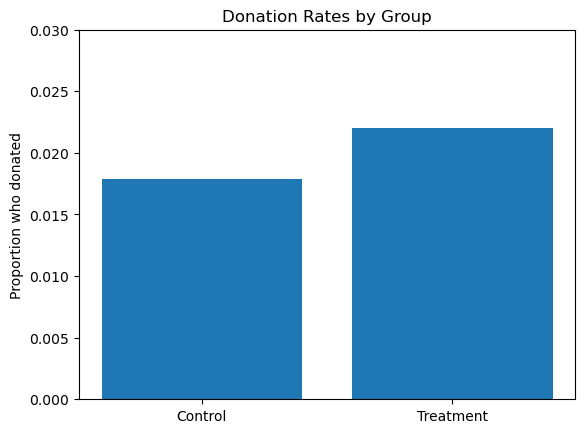

In [26]:
import matplotlib.pyplot as plt

plt.bar(donation_rates.index, donation_rates.values)
plt.ylabel("Proportion who donated")
plt.title("Donation Rates by Group")
plt.ylim(0, 0.03)
plt.show()

In [27]:
# Manual t-test using class formula
treated = df[df["treatment"] == 1]["gave"].dropna()
control = df[df["treatment"] == 0]["gave"].dropna()

x_t, x_c = treated.mean(), control.mean()
s2_t, s2_c = treated.var(), control.var()
n_t, n_c = len(treated), len(control)

t_stat = (x_t - x_c) / ((s2_t/n_t + s2_c/n_c) ** 0.5)

# Welch–Satterthwaite degrees of freedom
df_num = (s2_t/n_t + s2_c/n_c)**2
df_denom = ((s2_t/n_t)**2)/(n_t - 1) + ((s2_c/n_c)**2)/(n_c - 1)
dof = df_num / df_denom

# Two-sided p-value
p_val = 2 * t_dist.sf(abs(t_stat), dof)

print(f"Manual t-stat: {t_stat:.3f}")
print(f"Manual p-value: {p_val:.4f}")

Manual t-stat: 3.209
Manual p-value: 0.0013


In [44]:
# Linear regression
model_lin = smf.ols("gave ~ treatment", data=df).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                   gave   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.618
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00193
Time:                        14:37:14   Log-Likelihood:                 26630.
No. Observations:               50083   AIC:                        -5.326e+04
Df Residuals:                   50081   BIC:                        -5.324e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0179      0.001     16.225      0.0

In [29]:
# Probit regression
model_probit = smf.probit("gave ~ treatment", data=df).fit()
print(model_probit.summary())

Optimization terminated successfully.
         Current function value: 0.100443
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                   gave   No. Observations:                50083
Model:                         Probit   Df Residuals:                    50081
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:               0.0009783
Time:                        14:36:45   Log-Likelihood:                -5030.5
converged:                       True   LL-Null:                       -5035.4
Covariance Type:            nonrobust   LLR p-value:                  0.001696
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1001      0.023    -90.073      0.000      -2.146      -2.054
treatment      0.0868      0.

### Differences between Match Rates

In [30]:
# Subset to treatment group
treat_group = df[df["treatment"] == 1]

# Example: compare 2:1 vs 1:1
x2 = treat_group[treat_group["ratio2"] == 1]["gave"]
x1 = treat_group[treat_group["ratio"] == 1]["gave"]

x_t, x_c = x2.mean(), x1.mean()
s2_t, s2_c = x2.var(), x1.var()
n_t, n_c = len(x2), len(x1)

t_stat = (x_t - x_c) / ((s2_t/n_t + s2_c/n_c) ** 0.5)

# Welch–Satterthwaite degrees of freedom
df_num = (s2_t/n_t + s2_c/n_c)**2
df_denom = ((s2_t/n_t)**2)/(n_t - 1) + ((s2_c/n_c)**2)/(n_c - 1)
dof = df_num / df_denom

# Two-sided p-value
p_val = 2 * t_dist.sf(abs(t_stat), dof)

print(f"Manual t-stat: {t_stat:.3f}")
print(f"Manual p-value: {p_val:.4f}")

Manual t-stat: 0.965
Manual p-value: 0.3345


In [31]:
# Example: compare 2:1 vs 3:1
x2 = treat_group[treat_group["ratio2"] == 1]["gave"]
x3 = treat_group[treat_group["ratio"] == 1]["gave"]

x_t, x_c = x2.mean(), x3.mean()
s2_t, s2_c = x2.var(), x3.var()
n_t, n_c = len(x2), len(x3)

t_stat = (x_t - x_c) / ((s2_t/n_t + s2_c/n_c) ** 0.5)

# Welch–Satterthwaite degrees of freedom
df_num = (s2_t/n_t + s2_c/n_c)**2
df_denom = ((s2_t/n_t)**2)/(n_t - 1) + ((s2_c/n_c)**2)/(n_c - 1)
dof = df_num / df_denom

# Two-sided p-value
p_val = 2 * t_dist.sf(abs(t_stat), dof)

print(f"Manual t-stat: {t_stat:.3f}")
print(f"Manual p-value: {p_val:.4f}")

Manual t-stat: 0.965
Manual p-value: 0.3345


In [32]:
# Example: compare 1:1 vs 3:1
x1 = treat_group[treat_group["ratio2"] == 1]["gave"]
x3 = treat_group[treat_group["ratio"] == 1]["gave"]

x_t, x_c = x1.mean(), x3.mean()
s2_t, s2_c = x1.var(), x3.var()
n_t, n_c = len(x1), len(x3)

t_stat = (x_t - x_c) / ((s2_t/n_t + s2_c/n_c) ** 0.5)

# Welch–Satterthwaite degrees of freedom
df_num = (s2_t/n_t + s2_c/n_c)**2
df_denom = ((s2_t/n_t)**2)/(n_t - 1) + ((s2_c/n_c)**2)/(n_c - 1)
dof = df_num / df_denom

# Two-sided p-value
p_val = 2 * t_dist.sf(abs(t_stat), dof)

print(f"Manual t-stat: {t_stat:.3f}")
print(f"Manual p-value: {p_val:.4f}")

Manual t-stat: 0.965
Manual p-value: 0.3345


In [33]:
import pandas as pd
import statsmodels.formula.api as smf

# Run regression with 1:1 as baseline (ratio1 is omitted)
model = smf.ols("gave ~ ratio2 + ratio3", data=treat_group).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   gave   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6454
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.524
Time:                        14:36:45   Log-Likelihood:                 16688.
No. Observations:               33396   AIC:                        -3.337e+04
Df Residuals:                   33393   BIC:                        -3.334e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0207      0.001     14.912      0.0

In [34]:
import pandas as pd
import statsmodels.formula.api as smf

# Raw response rates by match ratio

# Create match ratio group labels
def get_ratio(row):
    if row["ratio2"] == 1:
        return "2:1"
    elif row["ratio3"] == 1:
        return "3:1"
    else:
        return "1:1"

treat_group["ratio_group"] = treat_group.apply(get_ratio, axis=1)

# Calculate mean donation rate by group
donation_rates = treat_group.groupby("ratio_group")["gave"].mean()
print("Raw Donation Rates by Match Ratio:\n", donation_rates)

# --- 2. Differences in fitted coefficients (from previous regression) ---
model = smf.ols("gave ~ ratio2 + ratio3", data=treat_group).fit()
coef_1_1 = model.params['Intercept']
coef_2_1 = coef_1_1 + model.params['ratio2']
coef_3_1 = coef_1_1 + model.params['ratio3']

print("\nFitted Coefficients:")
print(f"1:1 donation rate (Intercept): {coef_1_1:.4f}")
print(f"2:1 estimated rate: {coef_2_1:.4f}")
print(f"3:1 estimated rate: {coef_3_1:.4f}")

# --- 3. Compute response rate differences ---
print("\nDifferences in response rates (from regression):")
print(f"2:1 − 1:1: {model.params['ratio2']:.4f}")
print(f"3:1 − 1:1: {model.params['ratio3']:.4f}")
print(f"3:1 − 2:1: {model.params['ratio3'] - model.params['ratio2']:.4f}")


Raw Donation Rates by Match Ratio:
 ratio_group
1:1    0.020749
2:1    0.022633
3:1    0.022733
Name: gave, dtype: float64

Fitted Coefficients:
1:1 donation rate (Intercept): 0.0207
2:1 estimated rate: 0.0226
3:1 estimated rate: 0.0227

Differences in response rates (from regression):
2:1 − 1:1: 0.0019
3:1 − 1:1: 0.0020
3:1 − 2:1: 0.0001


/tmp/ipykernel_5387/3286036591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_group["ratio_group"] = treat_group.apply(get_ratio, axis=1)


In [35]:
# Raw response rates by match ratio

# Create match ratio group labels
def get_ratio(row):
    if row["ratio2"] == 1:
        return "2:1"
    elif row["ratio3"] == 1:
        return "3:1"
    else:
        return "1:1"

treat_group["ratio_group"] = treat_group.apply(get_ratio, axis=1)


/tmp/ipykernel_5387/716834291.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_group["ratio_group"] = treat_group.apply(get_ratio, axis=1)


In [36]:
# Create match ratio group labels
def get_ratio(row):
    if row["ratio2"] == 1:
        return "2:1"
    elif row["ratio3"] == 1:
        return "3:1"
    else:
        return "1:1"

# Safely add the new column
treat_group.loc[:, "ratio_group"] = treat_group.apply(get_ratio, axis=1)

# Calculate mean donation rate by group
donation_rates = treat_group.groupby("ratio_group")["gave"].mean()
print("Raw Donation Rates by Match Ratio:\n", donation_rates)



Raw Donation Rates by Match Ratio:
 ratio_group
1:1    0.020749
2:1    0.022633
3:1    0.022733
Name: gave, dtype: float64


### Size of Charitable Contribution

In [37]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# Compare donation amounts across all individuals
# (most people donated $0)
treated = df[df["treatment"] == 1]["amount"].dropna()
control = df[df["treatment"] == 0]["amount"].dropna()

# T-test
t_stat, p_val = ttest_ind(treated, control, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.4f}")

# Linear regression (everyone)
model_all = smf.ols("amount ~ treatment", data=df).fit()
print(model_all.summary())


T-test: t = 1.918, p = 0.0551
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.461
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0628
Time:                        14:36:46   Log-Likelihood:            -1.7946e+05
No. Observations:               50083   AIC:                         3.589e+05
Df Residuals:                   50081   BIC:                         3.589e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8133 

In [38]:
# Filter only donors (those who gave a positive amount)
donors = df[df["gave"] == 1]

# Compare mean donation amounts between treatment & control among donors
treated_donors = donors[donors["treatment"] == 1]["amount"]
control_donors = donors[donors["treatment"] == 0]["amount"]

t_stat, p_val = ttest_ind(treated_donors, control_donors, equal_var=False)
print(f"T-test (donors only): t = {t_stat:.3f}, p = {p_val:.4f}")

# Run regression: amount ~ treatment
model_donors = smf.ols("amount ~ treatment", data=donors).fit()

# Output summary
print(model_donors.summary())

T-test (donors only): t = -0.585, p = 0.5590
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3374
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.561
Time:                        14:36:46   Log-Likelihood:                -5326.8
No. Observations:                1034   AIC:                         1.066e+04
Df Residuals:                    1032   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

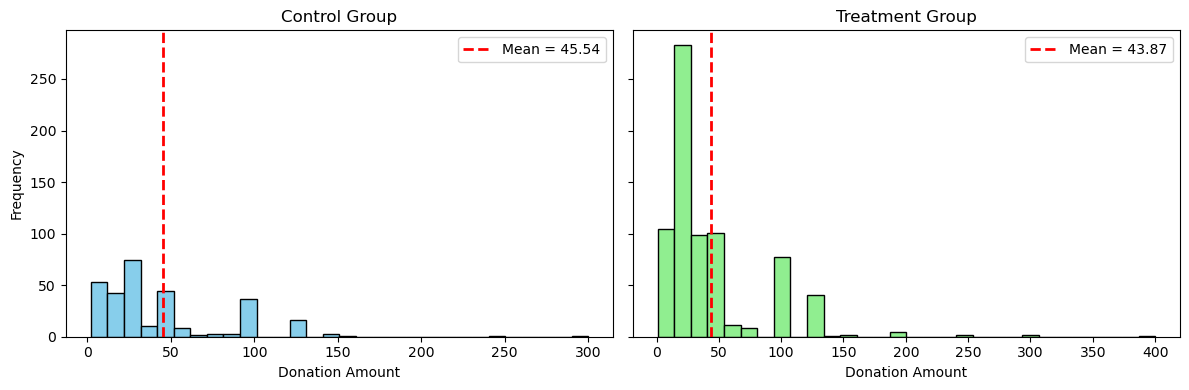

In [39]:
import matplotlib.pyplot as plt

# Subset only those who donated
donors = df[df["gave"] == 1]

# Split by treatment
treatment_donors = donors[donors["treatment"] == 1]["amount"]
control_donors = donors[donors["treatment"] == 0]["amount"]

# Compute means
mean_treat = treatment_donors.mean()
mean_control = control_donors.mean()

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Control group plot
axes[0].hist(control_donors, bins=30, color='skyblue', edgecolor='black')
axes[0].axvline(mean_control, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_control:.2f}")
axes[0].set_title("Control Group")
axes[0].set_xlabel("Donation Amount")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Treatment group plot
axes[1].hist(treatment_donors, bins=30, color='lightgreen', edgecolor='black')
axes[1].axvline(mean_treat, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_treat:.2f}")
axes[1].set_title("Treatment Group")
axes[1].set_xlabel("Donation Amount")
axes[1].legend()

plt.tight_layout()
plt.show()

## Simulation Experiment

### Law of Large Numbers

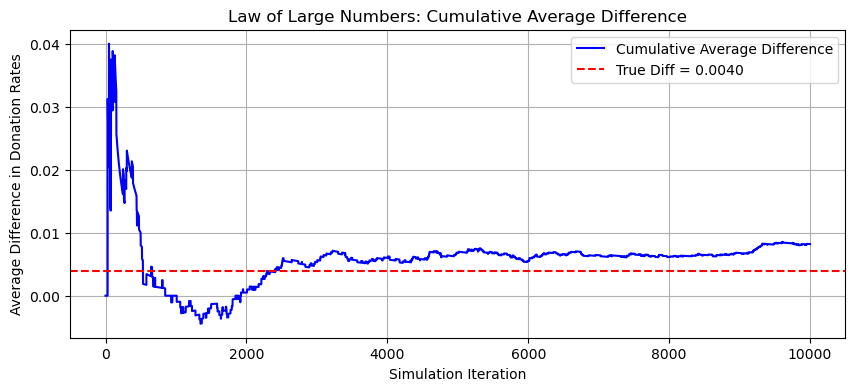

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Simulation parameters
n = 10000
p_control = 0.018
p_treatment = 0.022

# Simulate donations (1 = gave, 0 = didn't)
control_draws = np.random.binomial(1, p_control, n)
treatment_draws = np.random.binomial(1, p_treatment, n)

# Compute stepwise differences in donation outcomes
diffs = treatment_draws - control_draws

# Cumulative average of differences
cumulative_avg_diff = np.cumsum(diffs) / np.arange(1, n+1)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_avg_diff, label='Cumulative Average Difference', color='blue')
plt.axhline(p_treatment - p_control, color='red', linestyle='dashed', label=f"True Diff = {p_treatment - p_control:.004f}")
plt.title("Law of Large Numbers: Cumulative Average Difference")
plt.xlabel("Simulation Iteration")
plt.ylabel("Average Difference in Donation Rates")
plt.legend()
plt.grid(True)
plt.show()


### Central Limit Theorem

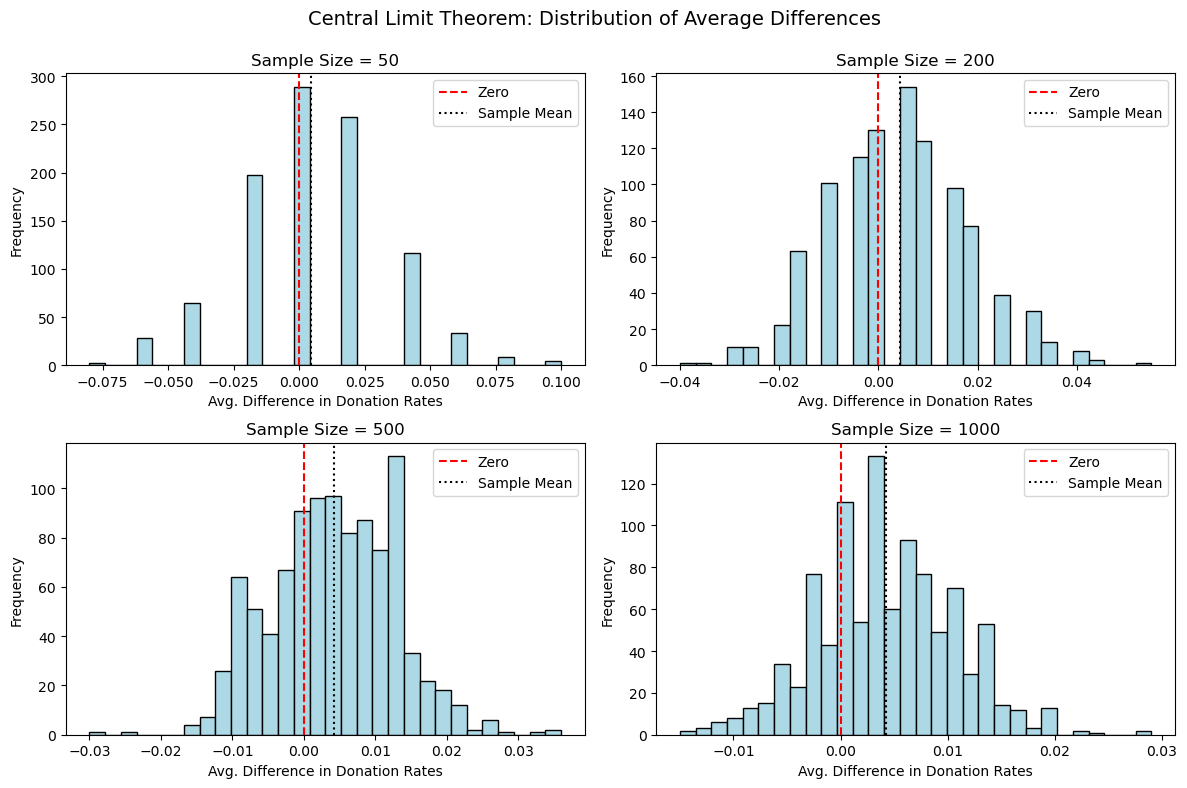

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

# Parameters
p_control = 0.018
p_treatment = 0.022
sample_sizes = [50, 200, 500, 1000]
num_simulations = 1000

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, n in enumerate(sample_sizes):
    avg_diffs = []

    for _ in range(num_simulations):
        control_sample = np.random.binomial(1, p_control, n)
        treatment_sample = np.random.binomial(1, p_treatment, n)
        diff = treatment_sample.mean() - control_sample.mean()
        avg_diffs.append(diff)

    # Plot histogram
    axes[i].hist(avg_diffs, bins=30, color='lightblue', edgecolor='black')
    axes[i].axvline(x=0, color='red', linestyle='dashed', label='Zero')
    axes[i].axvline(x=np.mean(avg_diffs), color='black', linestyle='dotted', label='Sample Mean')
    axes[i].set_title(f"Sample Size = {n}")
    axes[i].set_xlabel("Avg. Difference in Donation Rates")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.suptitle("Central Limit Theorem: Distribution of Average Differences", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
